In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
# 跳转文件目录到当前文件运行的文件夹。
path = "/content/drive/My Drive/Colab Notebooks/RAE"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['outputs',
 'ImShow.py',
 'shrink',
 'AddNoise',
 '__pycache__',
 'model',
 'data',
 'RAE_l21_Anomalous_Feature.ipynb',
 'RAE_Denoising.ipynb',
 'RAE_l21_Instance_Detection.ipynb']

# Load package

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


import torch.nn.functional as F
from torch import nn, optim
import torch
from torch import optim
from torchvision import datasets, transforms

# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Import the model and methods that defined by us

In [3]:
from AddNoise import addnoise
from model.DeepAutoencoder import DAE
import ImShow as I

from shrink import l21shrink as SHR
from model.train import train 

In [4]:
BATCH_SIZE = 100

LEARNING_RATE = 1e-3

EPOCH = 10

data = np.load('./data/data.npk', allow_pickle=True)
y = np.load("./data/y.npk", allow_pickle=True)
torch.tensor(data).shape

train_data = torch.tensor(data)
train_label = torch.tensor(y).view((5124,1))


## Robust Deep autoencoder (anomaly detaction)

In [16]:
class RDAE(object):
  def __init__(self, lambda_=1.0, error=1.0e-5):
    super(RDAE,self).__init__()
    self.lambda_ = lambda_
    self.error = error
    self.AE = DAE()

  def fit(self, X, iteration=5, epoch=8):
    self.AE.to(device)
    optimizer = optim.Adam(self.AE.parameters(), lr=LEARNING_RATE)
    error = self.error
    lambda_ = self.lambda_

    L = torch.zeros(X.shape)
    S = torch.zeros(X.shape)

    LS0 = L + S

    XFnorm = torch.norm(X, 'fro')
    mu = (len(X))/(4.0 * torch.norm(X, 1))

    # move to the device
    X = X.to(device)
    L = L.to(device)
    S = S.to(device)
    LS0 = LS0.to(device)

    # add noise to X
    # X = addnoise.add_noise_uniform_normal(X, 100)

    for i in range(iteration):
      # updata L
      L = X - S

      # generate train data
      train_datas = torch.utils.data.DataLoader(L, batch_size = BATCH_SIZE, shuffle=False)
      
      train(train_datas, self.AE, optimizer, epoch)
      
      with torch.no_grad():
        # get optimized L
        L = self.AE(L.float())
        
        # S = shrink_anomly(lambda_/mu, (X-L))
        S = SHR.shrink(lambda_, (X-L).t()).t()

      # break criterion 1: the L and S are close enough to X
        c1 = torch.norm(X-L-S, 'fro') / XFnorm

      # break criterion 2: there is no changes for L and S
        c2 = torch.min(mu, torch.sqrt(mu)) * torch.norm(LS0 - L - S) / XFnorm

        if c1 < error and c2 < error:
          print("early break")
          break
      LS0 = L + S
    return L, S

## Compute the f1 score
After we get the S, we need to select the non-zero index, then we can know if we detect the anomly correctly

In [6]:
import torch

def transform2lable(S):
  x = torch.norm(torch.tensor(S), 0, 1)
  x[torch.where(x == 0)[0]] = 4
  return x

def valid_criterion(pred_label, true_label):
  TP = ((pred_label != 4) & (true_label != 4)).cpu().sum()
  TN = ((pred_label == 4) & (true_label == 4)).cpu().sum()
  FN = ((pred_label == 4) & (true_label != 4)).cpu().sum()
  FP = ((pred_label != 4) & (true_label == 4)).cpu().sum()
  print(TP,TN,FN,FP)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1 = 2 * precision * recall / (precision+recall)
  accuracy = (TP+TN) / (TP+TN+FP+FN)

  return [precision, recall, F1, accuracy]

In [7]:
#. we search the best lambda from 2 to 7 with space 0,075
lambdas = np.arange(2,7,0.075)
result = []
for i in lambdas:
  print("=========lambda=======", i)
  model_RDAE = RDAE(lambda_=i)
  L, S = model_RDAE.fit(train_data)
  L = L.cpu().numpy()
  S = S.cpu().numpy()

  L_pics = I.tile_raster_images(L, (28,28), (10,10))
  S_pics = I.tile_raster_images(S, (28,28), (10,10))

  plt.imshow(L_pics, cmap='gray')
  plt.show()
  plt.imshow(S_pics, cmap='gray')
  plt.savefig("outputs/%.4f.png"%(i))
  plt.show()

  result.append(valid_criterion(transform2lable(S),train_label.view(-1)))
  print("%.30s%.30s%.30s%.30s" % ("precison", "recall", "f1", "accuracy"))
  print("%.30s%.30s%.30s%.30s" % tuple(result[-1]))


Output hidden; open in https://colab.research.google.com to view.

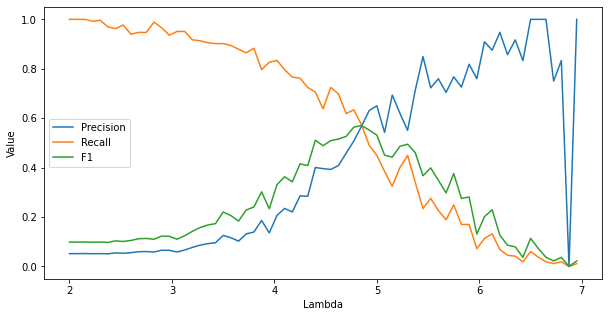

tensor(0.5704)


In [14]:
result_tensor = torch.tensor(result)
result_tensor[torch.where(torch.isnan(result_tensor))] = 0
m = result_tensor
plt.figure(figsize=(10,5))
plt.plot(lambdas, m[:,0], label='Precision')
plt.plot(lambdas, m[:,1], label='Recall')
plt.plot(lambdas, m[:,2], label='F1')
plt.xlabel("Lambda")
plt.ylabel("Value")
plt.savefig("Result_of_finding lambda")
plt.legend()
plt.show()

print(torch.max(m[:,2]))

## Here we found the best lambda is around 5, so we pick the values range from (4.5, 5, 0.075), to see if we can get better result by change the itertion and epochs.


lambda 4.5, epoch 5, iteration 3
tensor(172) tensor(4586) tensor(93) tensor(273)
precisonrecallf1accuracy
tensor(0.3865)tensor(0.6491)tensor(0.4845)tensor(0.9286)
lambda 4.5, epoch 5, iteration 5
tensor(186) tensor(4591) tensor(79) tensor(268)
precisonrecallf1accuracy
tensor(0.4097)tensor(0.7019)tensor(0.5174)tensor(0.9323)
lambda 4.5, epoch 5, iteration 8
tensor(186) tensor(4635) tensor(79) tensor(224)
precisonrecallf1accuracy
tensor(0.4537)tensor(0.7019)tensor(0.5511)tensor(0.9409)
lambda 4.5, epoch 10, iteration 3
tensor(182) tensor(4579) tensor(83) tensor(280)
precisonrecallf1accuracy
tensor(0.3939)tensor(0.6868)tensor(0.5007)tensor(0.9292)
lambda 4.5, epoch 10, iteration 5
tensor(171) tensor(4551) tensor(94) tensor(308)
precisonrecallf1accuracy
tensor(0.3570)tensor(0.6453)tensor(0.4597)tensor(0.9215)
lambda 4.5, epoch 10, iteration 8
tensor(190) tensor(4611) tensor(75) tensor(248)
precisonrecallf1accuracy
tensor(0.4338)tensor(0.7170)tensor(0.5405)tensor(0.9370)
lambda 4.575, epoch

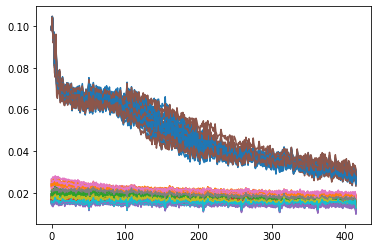

In [19]:
lambdas = np.arange(4.5,5,0.075)
epoch = np.array([5,10])
iteration = np.array([3,5,8])
result = []
for i in lambdas:
  for j in epoch:
    for k in iteration:
      print("lambda %.20s, epoch %.20s, iteration %.20s"% (i,j,k))
      model_RDAE = RDAE(lambda_=i)
      L, S = model_RDAE.fit(train_data)
      L = L.cpu().numpy()
      S = S.cpu().numpy()

      result.append(valid_criterion(transform2lable(S),train_label.view(-1)))
      print("%.30s%.30s%.30s%.30s" % ("precison", "recall", "f1", "accuracy"))
      print("%.30s%.30s%.30s%.30s" % tuple(result[-1]))

In [23]:
# lambda 4.7250000000000005, epoch 5, iteration 3
torch.max(torch.tensor(result)[:,2])

tensor(0.6083)